In [33]:
import pandas as pd
import numpy as np
import seaborn as sns

PATH_READ = '301085_train_raw.csv'
PATH_WRITE = '301085_train_withF.csv'
# df = pd.read_csv(PATH_READ, index_col='Timestamp')
df = pd.read_csv(PATH_READ)


Preprocessing, cleaning unwanted cols

In [34]:
df = df.drop(['InstrumentID','TradingDay','PreClosePrice',], axis=1)
# df.index = pd.to_datetime(df.index)

print(df.columns)

Index(['Timestamp', 'Open', 'High', 'Low', 'Volume', 'Turnover', 'Close'], dtype='object')


Add hist return features

In [35]:
def hist_ret_close(df, param):
    return df['Close'] / df['Close'].shift(param)

df.insert(loc=df.columns.get_loc('Close')+1, column= 'STOCK_Hist_Ret_Close_15min', value= hist_ret_close(df,15))
df.insert(loc=df.columns.get_loc('Close')+1, column= 'STOCK_Hist_Ret_Close_10min', value= hist_ret_close(df,10))
df.insert(loc=df.columns.get_loc('Close')+1, column= 'STOCK_Hist_Ret_Close_5min', value= hist_ret_close(df,5))
df.insert(loc=df.columns.get_loc('Close')+1, column= 'STOCK_Hist_Ret_Close_3min', value= hist_ret_close(df,3))

print(df.columns)

Index(['Timestamp', 'Open', 'High', 'Low', 'Volume', 'Turnover', 'Close',
       'STOCK_Hist_Ret_Close_3min', 'STOCK_Hist_Ret_Close_5min',
       'STOCK_Hist_Ret_Close_10min', 'STOCK_Hist_Ret_Close_15min'],
      dtype='object')


Add log return features

In [36]:
df['STOCK_Log_Return_Close_1min'] = np.log(df['Close'] / df['Close'].shift(1))

print(df.columns)

Index(['Timestamp', 'Open', 'High', 'Low', 'Volume', 'Turnover', 'Close',
       'STOCK_Hist_Ret_Close_3min', 'STOCK_Hist_Ret_Close_5min',
       'STOCK_Hist_Ret_Close_10min', 'STOCK_Hist_Ret_Close_15min',
       'STOCK_Log_Return_Close_1min'],
      dtype='object')


Add average price and mean price from 4

In [37]:
df['Avg'] = df['Turnover']/df['Volume']

# For unchanged prices, fill zero

# 目前对于涨/跌停这种情况的策略是在数据里补0，也许可以用NaN然后删除？
# df['AvgPrice'].fillna(0, inplace=True)


nan_rows_Avg = df[df['Avg'].isnull()]

# 如遇涨/跌停，直接用高开低收的价格，因为都一样
for index, row in nan_rows_Avg.iterrows():
    if row['High'] == row['Low'] == row['Open'] == row['Close']:
        row['Avg'] = row['High']

df.update(nan_rows_Avg)

print(df)

df['4meanPrice'] = (df['High']+df['Low']+df['Close']+df['Open'])/4.0


                Timestamp   Open   High    Low    Volume   Turnover  Close  \
0     2023-06-01 09:26:00  45.55  45.55  45.55   17300.0   788015.0  45.55   
1     2023-06-01 09:31:00  45.64  46.62  45.61  124300.0  5732875.0  46.62   
2     2023-06-01 09:32:00  46.45  46.62  46.17   72100.0  3349057.0  46.17   
3     2023-06-01 09:33:00  46.27  46.52  46.10   52300.0  2421814.0  46.52   
4     2023-06-01 09:34:00  46.60  47.12  46.60  144800.0  6790040.0  46.92   
...                   ...    ...    ...    ...       ...        ...    ...   
5834  2023-07-06 14:58:00  69.28  69.28  69.28    2600.0   180102.0  69.28   
5835  2023-07-06 14:59:00  69.28  69.28  69.28       0.0        0.0  69.28   
5836  2023-07-06 15:00:00  69.28  69.28  69.28       0.0        0.0  69.28   
5837  2023-07-06 15:01:00  69.30  69.30  69.30   74100.0  5135130.0  69.30   
5838  2023-07-06 15:35:00  69.30  69.30  69.30       0.0        0.0  69.30   

      STOCK_Hist_Ret_Close_3min  STOCK_Hist_Ret_Close_5min  \
0

Add log return based on Avg

In [38]:
df['STOCK_Log_Return_Avg_1min'] = np.log(df['Avg'] / df['Avg'].shift(1))

print(df.columns)

Index(['Timestamp', 'Open', 'High', 'Low', 'Volume', 'Turnover', 'Close',
       'STOCK_Hist_Ret_Close_3min', 'STOCK_Hist_Ret_Close_5min',
       'STOCK_Hist_Ret_Close_10min', 'STOCK_Hist_Ret_Close_15min',
       'STOCK_Log_Return_Close_1min', 'Avg', '4meanPrice',
       'STOCK_Log_Return_Avg_1min'],
      dtype='object')


Hist based on avg price

In [39]:
def hist_ret_avg(df, param):
    return df['Avg'] / df['Avg'].shift(param)

df['STOCK_Hist_Ret_Avg_3min'] = hist_ret_avg(df, 3)
df['STOCK_Hist_Ret_Avg_5min'] = hist_ret_avg(df, 5)
df['STOCK_Hist_Ret_Avg_10min'] = hist_ret_avg(df, 10)
df['STOCK_Hist_Ret_Avg_15min'] = hist_ret_avg(df, 15)

Experiment with rolling volatility

In [40]:
def rolling_std(df, window_size):
    return df['Close'].rolling(window=window_size).std()

df['STOCK_Vol_5min_Close'] = rolling_std(df, 5)
df['STOCK_Vol_10min_Close'] = rolling_std(df, 10)
df['STOCK_Vol_15min_Close'] = rolling_std(df, 15)

print(df.columns)

Index(['Timestamp', 'Open', 'High', 'Low', 'Volume', 'Turnover', 'Close',
       'STOCK_Hist_Ret_Close_3min', 'STOCK_Hist_Ret_Close_5min',
       'STOCK_Hist_Ret_Close_10min', 'STOCK_Hist_Ret_Close_15min',
       'STOCK_Log_Return_Close_1min', 'Avg', '4meanPrice',
       'STOCK_Log_Return_Avg_1min', 'STOCK_Hist_Ret_Avg_3min',
       'STOCK_Hist_Ret_Avg_5min', 'STOCK_Hist_Ret_Avg_10min',
       'STOCK_Hist_Ret_Avg_15min', 'STOCK_Vol_5min_Close',
       'STOCK_Vol_10min_Close', 'STOCK_Vol_15min_Close'],
      dtype='object')


Add Triple Barrier Target

<Axes: >

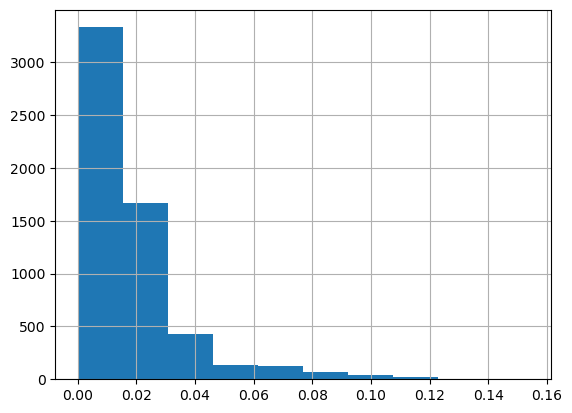

In [41]:
df['15min_range'] = df['High'].rolling(15).max() - df['Low'].rolling(15).min()
(df['15min_range'] /df['High']).hist()

In [42]:
def getDailyVol(data, span=30):
    df = data.assign(Return = lambda x: data['Close'] / data['Close'].shift(1)-1)
    sigma = df['Return'].ewm(span=span).std()
    return sigma

vol = getDailyVol(data=df)

In [43]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

events = df[['Timestamp']].copy(deep=True)
events['VB'] = df['Timestamp'] + pd.Timedelta(minutes=15)
events['Vol'] = vol

print(events)

               Timestamp                  VB       Vol
0    2023-06-01 09:26:00 2023-06-01 09:41:00       NaN
1    2023-06-01 09:31:00 2023-06-01 09:46:00       NaN
2    2023-06-01 09:32:00 2023-06-01 09:47:00  0.023436
3    2023-06-01 09:33:00 2023-06-01 09:48:00  0.016309
4    2023-06-01 09:34:00 2023-06-01 09:49:00  0.013123
...                  ...                 ...       ...
5834 2023-07-06 14:58:00 2023-07-06 15:13:00  0.000858
5835 2023-07-06 14:59:00 2023-07-06 15:14:00  0.000831
5836 2023-07-06 15:00:00 2023-07-06 15:15:00  0.000805
5837 2023-07-06 15:01:00 2023-07-06 15:16:00  0.000779
5838 2023-07-06 15:35:00 2023-07-06 15:50:00  0.000755

[5839 rows x 3 columns]


In [44]:
def TBL(df, events, width):
    
    res = events[['Timestamp', 'VB']].copy(deep=True)
    
    if width[0] > 0: events['UB'] = width[0]*events['Vol']
    else: events['UB'] = np.nan
        
    if width[1] > 0: events['DB'] = -width[1]*events['Vol']
    else: events['DB'] = np.nan
        
    for col,date,vb in res.itertuples():
        df0 = df[(df['Timestamp'] > date) & (df['Timestamp'] < vb)].copy(deep=True)
        df0['Return'] = df0['Close'] / df.loc[df['Timestamp'] == date, 'Close'].iloc[0]-1
        
        idx = (res['Timestamp'] == date)
        
        res.loc[idx, 'ut'] = df0.loc[df0['Return'] > events.loc[idx,'UB'].iloc[0], 'Timestamp'].min()
        res.loc[idx, 'dt'] = df0.loc[df0['Return'] < events.loc[idx,'DB'].iloc[0], 'Timestamp'].min()
            
    return res

In [45]:
def get_first_touch(df, events, width):
    res = TBL(df, events, width)
    res['First'] = res[['VB', 'ut', 'dt']].dropna(how='all').min(axis=1)
    return res

# 上下栅栏的宽度由 vol(span) * 系数[up,down] 决定
result = get_first_touch(df,events,width = [0.4,0.4])
print(result)

               Timestamp                  VB                  ut  dt  \
0    2023-06-01 09:26:00 2023-06-01 09:41:00                 NaT NaT   
1    2023-06-01 09:31:00 2023-06-01 09:46:00                 NaT NaT   
2    2023-06-01 09:32:00 2023-06-01 09:47:00 2023-06-01 09:34:00 NaT   
3    2023-06-01 09:33:00 2023-06-01 09:48:00 2023-06-01 09:34:00 NaT   
4    2023-06-01 09:34:00 2023-06-01 09:49:00 2023-06-01 09:38:00 NaT   
...                  ...                 ...                 ...  ..   
5834 2023-07-06 14:58:00 2023-07-06 15:13:00                 NaT NaT   
5835 2023-07-06 14:59:00 2023-07-06 15:14:00                 NaT NaT   
5836 2023-07-06 15:00:00 2023-07-06 15:15:00                 NaT NaT   
5837 2023-07-06 15:01:00 2023-07-06 15:16:00                 NaT NaT   
5838 2023-07-06 15:35:00 2023-07-06 15:50:00                 NaT NaT   

                   First  
0    2023-06-01 09:41:00  
1    2023-06-01 09:46:00  
2    2023-06-01 09:34:00  
3    2023-06-01 09:34:00  


In [46]:
def get_label(df,result):
    result = result.dropna(subset=['First'])
    outcome = result[['Timestamp']].copy(deep=True)
    
    price_t0 = pd.merge(result,df,on=['Timestamp'],how='left')['Close']
    price_t1 = pd.merge(result,df,left_on=['First'], right_on=['Timestamp'], how = 'left')['Close']
    
    outcome['Return'] = price_t1/price_t0-1
    outcome['TB_15min_Label'] = np.sign(outcome['Return'].dropna())
    
    outcome = outcome.drop(['Return'], axis = 1)

    return outcome

outcome = get_label(df,result)
print(outcome)

df = pd.merge(df,outcome, on=['Timestamp'],how='inner')

               Timestamp  TB_15min_Label
0    2023-06-01 09:26:00             1.0
1    2023-06-01 09:31:00             1.0
2    2023-06-01 09:32:00             1.0
3    2023-06-01 09:33:00             1.0
4    2023-06-01 09:34:00             1.0
...                  ...             ...
5834 2023-07-06 14:58:00             NaN
5835 2023-07-06 14:59:00             NaN
5836 2023-07-06 15:00:00             NaN
5837 2023-07-06 15:01:00             NaN
5838 2023-07-06 15:35:00             NaN

[5839 rows x 2 columns]


Cleaning NaN and unwanted data

In [47]:
# print('Number of rows before cleaning: %d'%df.shape[0])

df.index = df['Timestamp']
df = df.drop(['Timestamp'], axis=1)

# df = df[(df['Target_Close_1min'] != 0)
#                       & (df['Target_Close_5min_Mean'] != 0)
#                       & (df['Target_Close_10min_Mean'] != 0)
#                       & (df['Target_Close_15min_Mean'] != 0)
#                      ]
# pd.set_option ('mode.use_inf_as_na', True)
# df = df.dropna()


# print('Number of rows after cleaning: %d'%df.shape[0])

# print(df)

Saving CSV

In [48]:
df.to_csv(PATH_WRITE)